In [78]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,isnan, when, count
import seaborn as sns
import matplotlib.pyplot as plt 

print('Import successfull')

Import successfull


<u><h1>First Part</h1></u>
----------------------
very simple script to initialize a spark session and import a flat file.

In [3]:
# Init session
# Spark session creates entry point for application; lets you interact with Spark APIs
# getOrCreate() returns a new session if app exists or creates a new one
scSpark = SparkSession.builder.appName("reading csv").getOrCreate()

# read data
file_data = './Data/data.csv'
sdfData = scSpark.read.csv(file_data, header=True, sep=",").cache()
print(f'Total Records = {sdfData.count()}')
sdfData.show()

Total Records = 4
+------+---+--------+
|  name|age| country|
+------+---+--------+
| adnan| 40|Pakistan|
|  maaz|  9|Pakistan|
| musab|  4|Pakistan|
|ayesha| 32|Pakistan|
+------+---+--------+



<u><h1>Second Part</h1></u>
We will explore using SQL queries in Spark. We will be using real data which can be found on <a href=https://www.kaggle.com/aungpyaeap/supermarket-sales target=_blank>kaggle</a>.
<br>
<h2>Extract</h2>


In [19]:
# Extract the data
data_file = './Data/supermarket_sales - Sheet1.csv'
data = scSpark.read.csv(data_file, header=True, sep=",").cache()

#Explore the dataset
#Look at num of records
print(f'Total Records = {data.count()}')
#Look at schema
print('\nSchema')
print('--------------------------------------------------')
print(data.printSchema())
print('--------------------------------------------------\n')
print('Summary statistics')
print('--------------------------------------------------\n')
print(data.summary().show())

Total Records = 1000

Schema
--------------------------------------------------
root
 |-- Invoice ID: string (nullable = true)
 |-- Branch: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Customer type: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Product line: string (nullable = true)
 |-- Unit price: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Tax 5%: string (nullable = true)
 |-- Total: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Payment: string (nullable = true)
 |-- cogs: string (nullable = true)
 |-- gross margin percentage: string (nullable = true)
 |-- gross income: string (nullable = true)
 |-- Rating: string (nullable = true)

None
--------------------------------------------------

Summary statistics
--------------------------------------------------

+-------+-----------+------+--------+-------------+------+--------------------+------------------+----

<h2>Transform</h2>

In [20]:
# group data by gender

gender = data.groupBy('Gender').count()
print(gender.show())

+------+-----+
|Gender|count|
+------+-----+
|Female|  501|
|  Male|  499|
+------+-----+

None


In [22]:
# Create temporary table of sales
# query the temporary table to select all fields

data.registerTempTable('sales')
output = scSpark.sql('SELECT * FROM sales')
output.show()

+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-----+-----------+------+-----------------------+------------+------+
| Invoice ID|Branch|     City|Customer type|Gender|        Product line|Unit price|Quantity| Tax 5%|   Total|     Date| Time|    Payment|  cogs|gross margin percentage|gross income|Rating|
+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-----+-----------+------+-----------------------+------------+------+
|750-67-8428|     A|   Yangon|       Member|Female|   Health and beauty|     74.69|       7|26.1415|548.9715| 1/5/2019|13:08|    Ewallet|522.83|            4.761904762|     26.1415|   9.1|
|226-31-3081|     C|Naypyitaw|       Normal|Female|Electronic access...|     15.28|       5|   3.82|   80.22| 3/8/2019|10:29|       Cash|  76.4|            4.761904762|        3.82|   9.6|
|631-41-3108|     A|   Yangon|       Normal|  Male|  Ho

In [23]:
# Modify previous query to add WHERE clause

output2 = scSpark.sql('SELECT * \
                    FROM sales \
                    WHERE `Unit Price` < 15 AND Quantity < 10 ')
output2.show()

+-----------+------+---------+-------------+------+--------------------+----------+--------+------+--------+---------+-----+-----------+------+-----------------------+------------+------+
| Invoice ID|Branch|     City|Customer type|Gender|        Product line|Unit price|Quantity|Tax 5%|   Total|     Date| Time|    Payment|  cogs|gross margin percentage|gross income|Rating|
+-----------+------+---------+-------------+------+--------------------+----------+--------+------+--------+---------+-----+-----------+------+-----------------------+------------+------+
|351-62-0822|     B| Mandalay|       Member|Female| Fashion accessories|     14.48|       4| 2.896|  60.816| 2/6/2019|18:07|    Ewallet| 57.92|            4.761904762|       2.896|   4.5|
|871-39-9221|     C|Naypyitaw|       Normal|Female|Electronic access...|     12.45|       6| 3.735|  78.435| 2/9/2019|13:11|       Cash|  74.7|            4.761904762|       3.735|   4.1|
|586-25-0848|     A|   Yangon|       Normal|Female|   Sports

In [27]:
# Aggregate values

output3 = scSpark.sql('SELECT COUNT(*) as total, City FROM sales GROUP BY City')
output3.show()

+-----+---------+
|total|     City|
+-----+---------+
|  328|Naypyitaw|
|  332| Mandalay|
|  340|   Yangon|
+-----+---------+



<h2>Load</h2>

In [28]:
# Multiple files will be created
output3.write.format('json').save('filtered.json')

In [30]:
# to savve as only 1 file use coalesce
output3.coalesce(1).write.format('json').save('filtered_onefile.json')

# <u>Second Part</u>
## We can use pyspark to extract data from a database as well

We will access MySql with pyspark
The dataset can be found <a href='https://archive.ics.uci.edu/ml/datasets/Wine+Quality' target=_blank>here</a>

- First we will use panda to import the data, seperate red from white wines
  - no cleaning, eda, or nothing is done here
  - this step is just to create a MySql Database
- We will then write the results to a MySql database
- Then access the database using Pyspark


In [11]:
import pandas as pd
import mysql.connector

# Load data
red_wines = pd.read_csv('./winequality/winequality-red.csv', sep=";")
white_wines = pd.read_csv('./winequality/winequality-white.csv', sep=";")

# add coluns labeling type of wine: 1 for red 0 for white
red_wines['is_red'] = 1
white_wines['is_red'] = 0

# concat red and white wines dataframe into one
wines = pd.concat([red_wines, white_wines])

# Connect to MySql and add a cursor to execute queries
db_con = mysql.connector.connect(user='root', password='*****')
db_cursor = db_con.cursor()

# Create DataBase and create a Table
db_cursor.execute('CREATE DATABASE IF NOT EXISTS TestDB;')
db_cursor.execute('USE TestDB')

# Make column names in table match with the ones from the csv file
db_cursor.execute("CREATE TABLE IF NOT EXISTS Wines(fixed_acidity FLOAT, volatile_acidity FLOAT, \
                   citric_acid FLOAT, residual_sugar FLOAT, chlorides FLOAT, \
                   free_so2 FLOAT, total_so2 FLOAT, density FLOAT, pH FLOAT, \
                   sulphates FLOAT, alcohol FLOAT, quality INT, is_red INT);")

# Can load multiple rows in a MySQL table if the contents of each row is contained within parenthesis and comma seperated
# Match the syntax of INSERT
wine_tuples = list(wines.itertuples(index=False, name=None))
wine_tuples_string = ",".join(["(" + ",".join([str(w) for w in wt]) + ")" for wt in wine_tuples])

db_cursor.execute("INSERT INTO Wines(fixed_acidity, volatile_acidity, citric_acid,\
                   residual_sugar, chlorides, free_so2, total_so2, density, pH,\
                   sulphates, alcohol, quality, is_red) VALUES " + wine_tuples_string + ";")



In [11]:
# Check that the database and table were created and data sucessfully added to the table:
db_cursor.execute('SELECT * FROM Wines LIMIT 2;')
result1 = db_cursor.fetchall()
for x in result1:
    print(x)
    
print(wines.head(2))

# The results are kind of messy because the long column names makes the pandas result span multiple rows
# But you can compare the results between pandas and MySql amd see that the data matches

(7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 5, 1)
(7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.9968, 3.2, 0.68, 9.8, 5, 1)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70          0.0             1.9      0.076   
1            7.8              0.88          0.0             2.6      0.098   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   

   alcohol  quality  is_red  
0      9.4        5       1  
1      9.8        5       1  


None


## Access MySQL with Pyspark

Doing this can very quickly lead to massive headheaches...<br>
We are establishing a jdbc connection<br>
Make sure you have downloaded the correct MysQL connector (specifically the mysql-connector-java:$<version>$) and that the jar file is in the right location


In [2]:
spark = SparkSession.builder.config("spark.jars", "/usr/share/java/mysql-connector-java-8.0.22.jar") \
    .master("local").appName("PySpark_MySQL_test").getOrCreate()

In [4]:
import findspark

findspark.add_packages('mysql:mysql-connector-java:8.0.11')

In [7]:
wine_df = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3306/TestDB") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "Wines") \
    .option("user", "root").option("password", "*****").load()

In [48]:
# explore a bit :)
# SHow first 5 rows of dataframe
print(wine_df.show(n=5))

# Count number of rows
print(f'\nThe dataframe has {wine_df.count()} rows')

# Show number of partions in underlying RDD
print(f'Number of partitions = {wine_df.rdd.getNumPartitions()}')

# Get datatype of columns 
print(wine_df.printSchema())

# Get basic statistic of datframe
print(wine_df.describe().show())

# Calling describe() on the whole dataframe gives a messy output
# we can call it on a single column
print(wine_df.describe('volatile_acidity').show())

# We can also print the summary statistics of more than 1 col at a time
print(wine_df.describe(['volatile_acidity', 'citric_acid', 'alcohol', 'quality']).show())

# If we absolutely need the basic summary statistics of the whole data frame and need to format it to look nice
# we can can itterate over each column, find the statistics of that column, round the numbers to the desired format
# concat the results into a new data frame
# kind of a pain..

# Count NaN or Null or None values in dataframe
count_missing = wine_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in wine_df.columns])
print('Number of missing values in each column: ')
print(count_missing.show())

+-------------+----------------+-----------+--------------+---------+--------+---------+-------+----+---------+-------+-------+------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_so2|total_so2|density|  pH|sulphates|alcohol|quality|is_red|
+-------------+----------------+-----------+--------------+---------+--------+---------+-------+----+---------+-------+-------+------+
|          7.4|             0.7|        0.0|           1.9|    0.076|    11.0|     34.0| 0.9978|3.51|     0.56|    9.4|      5|     1|
|          7.8|            0.88|        0.0|           2.6|    0.098|    25.0|     67.0| 0.9968| 3.2|     0.68|    9.8|      5|     1|
|          7.8|            0.76|       0.04|           2.3|    0.092|    15.0|     54.0|  0.997|3.26|     0.65|    9.8|      5|     1|
|         11.2|            0.28|       0.56|           1.9|    0.075|    17.0|     60.0|  0.998|3.16|     0.58|    9.8|      6|     1|
|          7.4|             0.7|        0.0|           

# <u>Third Part</u>
## For completness, we can build a model and apply it to our data set using the MLlib library from Spark (still using pyspark)
 The dataset we are using is a pretty popular one used when learning machine learning. It is typically used to predict the quality of wine. The objective is to determine which features are the most important in determining the quality of the wine (and incidently, which are less important)<br>
 First thing we will do is fit a logistic regression model to predict if a given wine is red or white<br>
 Second thing we'll do is fit a RandomForest regression to the data to find the most and least important features in determining the quality of the wine

 ## Predicting if a given wine is red or white


In [76]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split the dataset
train_df, test_df = wine_df.randomSplit([.8, .2], seed=42) # 42 is the answer to life the universe and everything
predictors = wine_df.columns[:11] # use fixed_acidity to alcohol columns as predictors

# Vector assembler merges multiple cols into one vector column
vec_assembler = VectorAssembler(inputCols=predictors, outputCol='features')

# Logistic regression model
lr = LogisticRegression(labelCol='is_red', featuresCol='features')

# Build pipeline
pipeline = Pipeline(stages=[vec_assembler, lr])
pipeline_model = pipeline.fit(train_df)
predictions = pipeline_model.transform(test_df)

# Lets Look at the results
# we can play around to make these reslts more presentable, but that is not the objective here
predictions_pd = predictions.toPandas()
predictions_pd = predictions_pd[predictions_pd.columns[-5:]]
print(predictions_pd.head(10))

# logistic regression from pyspark returns 3 columns:
# rawPredictions is the value of the linear part of the model
# probability is the prob for each class
# prediction is the class prediction

# comput the accuracy
acc = BinaryClassificationEvaluator(labelCol='is_red')
pred_accuracy = acc.evaluate(predictions)
print(f'\nAccuracy of the model is {pred_accuracy}')

   is_red                                           features  \
0       0  [3.9, 0.225, 0.4, 4.2, 0.03, 29.0, 118.0, 0.98...   
1       0  [4.2, 0.215, 0.23, 5.1, 0.041, 64.0, 157.0, 0....   
2       0  [4.4, 0.32, 0.39, 4.3, 0.03, 31.0, 127.0, 0.98...   
3       0  [4.4, 0.54, 0.09, 5.1, 0.038, 52.0, 97.0, 0.99...   
4       1  [4.6, 0.52, 0.15, 2.1, 0.054, 8.0, 65.0, 0.993...   
5       0  [4.7, 0.335, 0.14, 1.3, 0.036, 69.0, 168.0, 0....   
6       0  [4.7, 0.67, 0.09, 1.0, 0.02, 5.0, 9.0, 0.98722...   
7       0  [4.8, 0.17, 0.28, 2.9, 0.03, 22.0, 111.0, 0.99...   
8       0  [4.8, 0.33, 0.0, 6.5, 0.028, 34.0, 163.0, 0.99...   
9       0  [4.8, 0.34, 0.0, 6.5, 0.028, 33.0, 163.0, 0.99...   

                               rawPrediction  \
0  [10.112050817830514, -10.112050817830514]   
1      [9.47470803022225, -9.47470803022225]   
2    [9.752104726823642, -9.752104726823642]   
3    [3.804423159955267, -3.804423159955267]   
4    [-2.202998150494626, 2.202998150494626]   
5    [7

 now that we fit a cute little logistic regression model to determine if a given wine is red or white, lets fit another model to determine the most important wine features to determine the quality

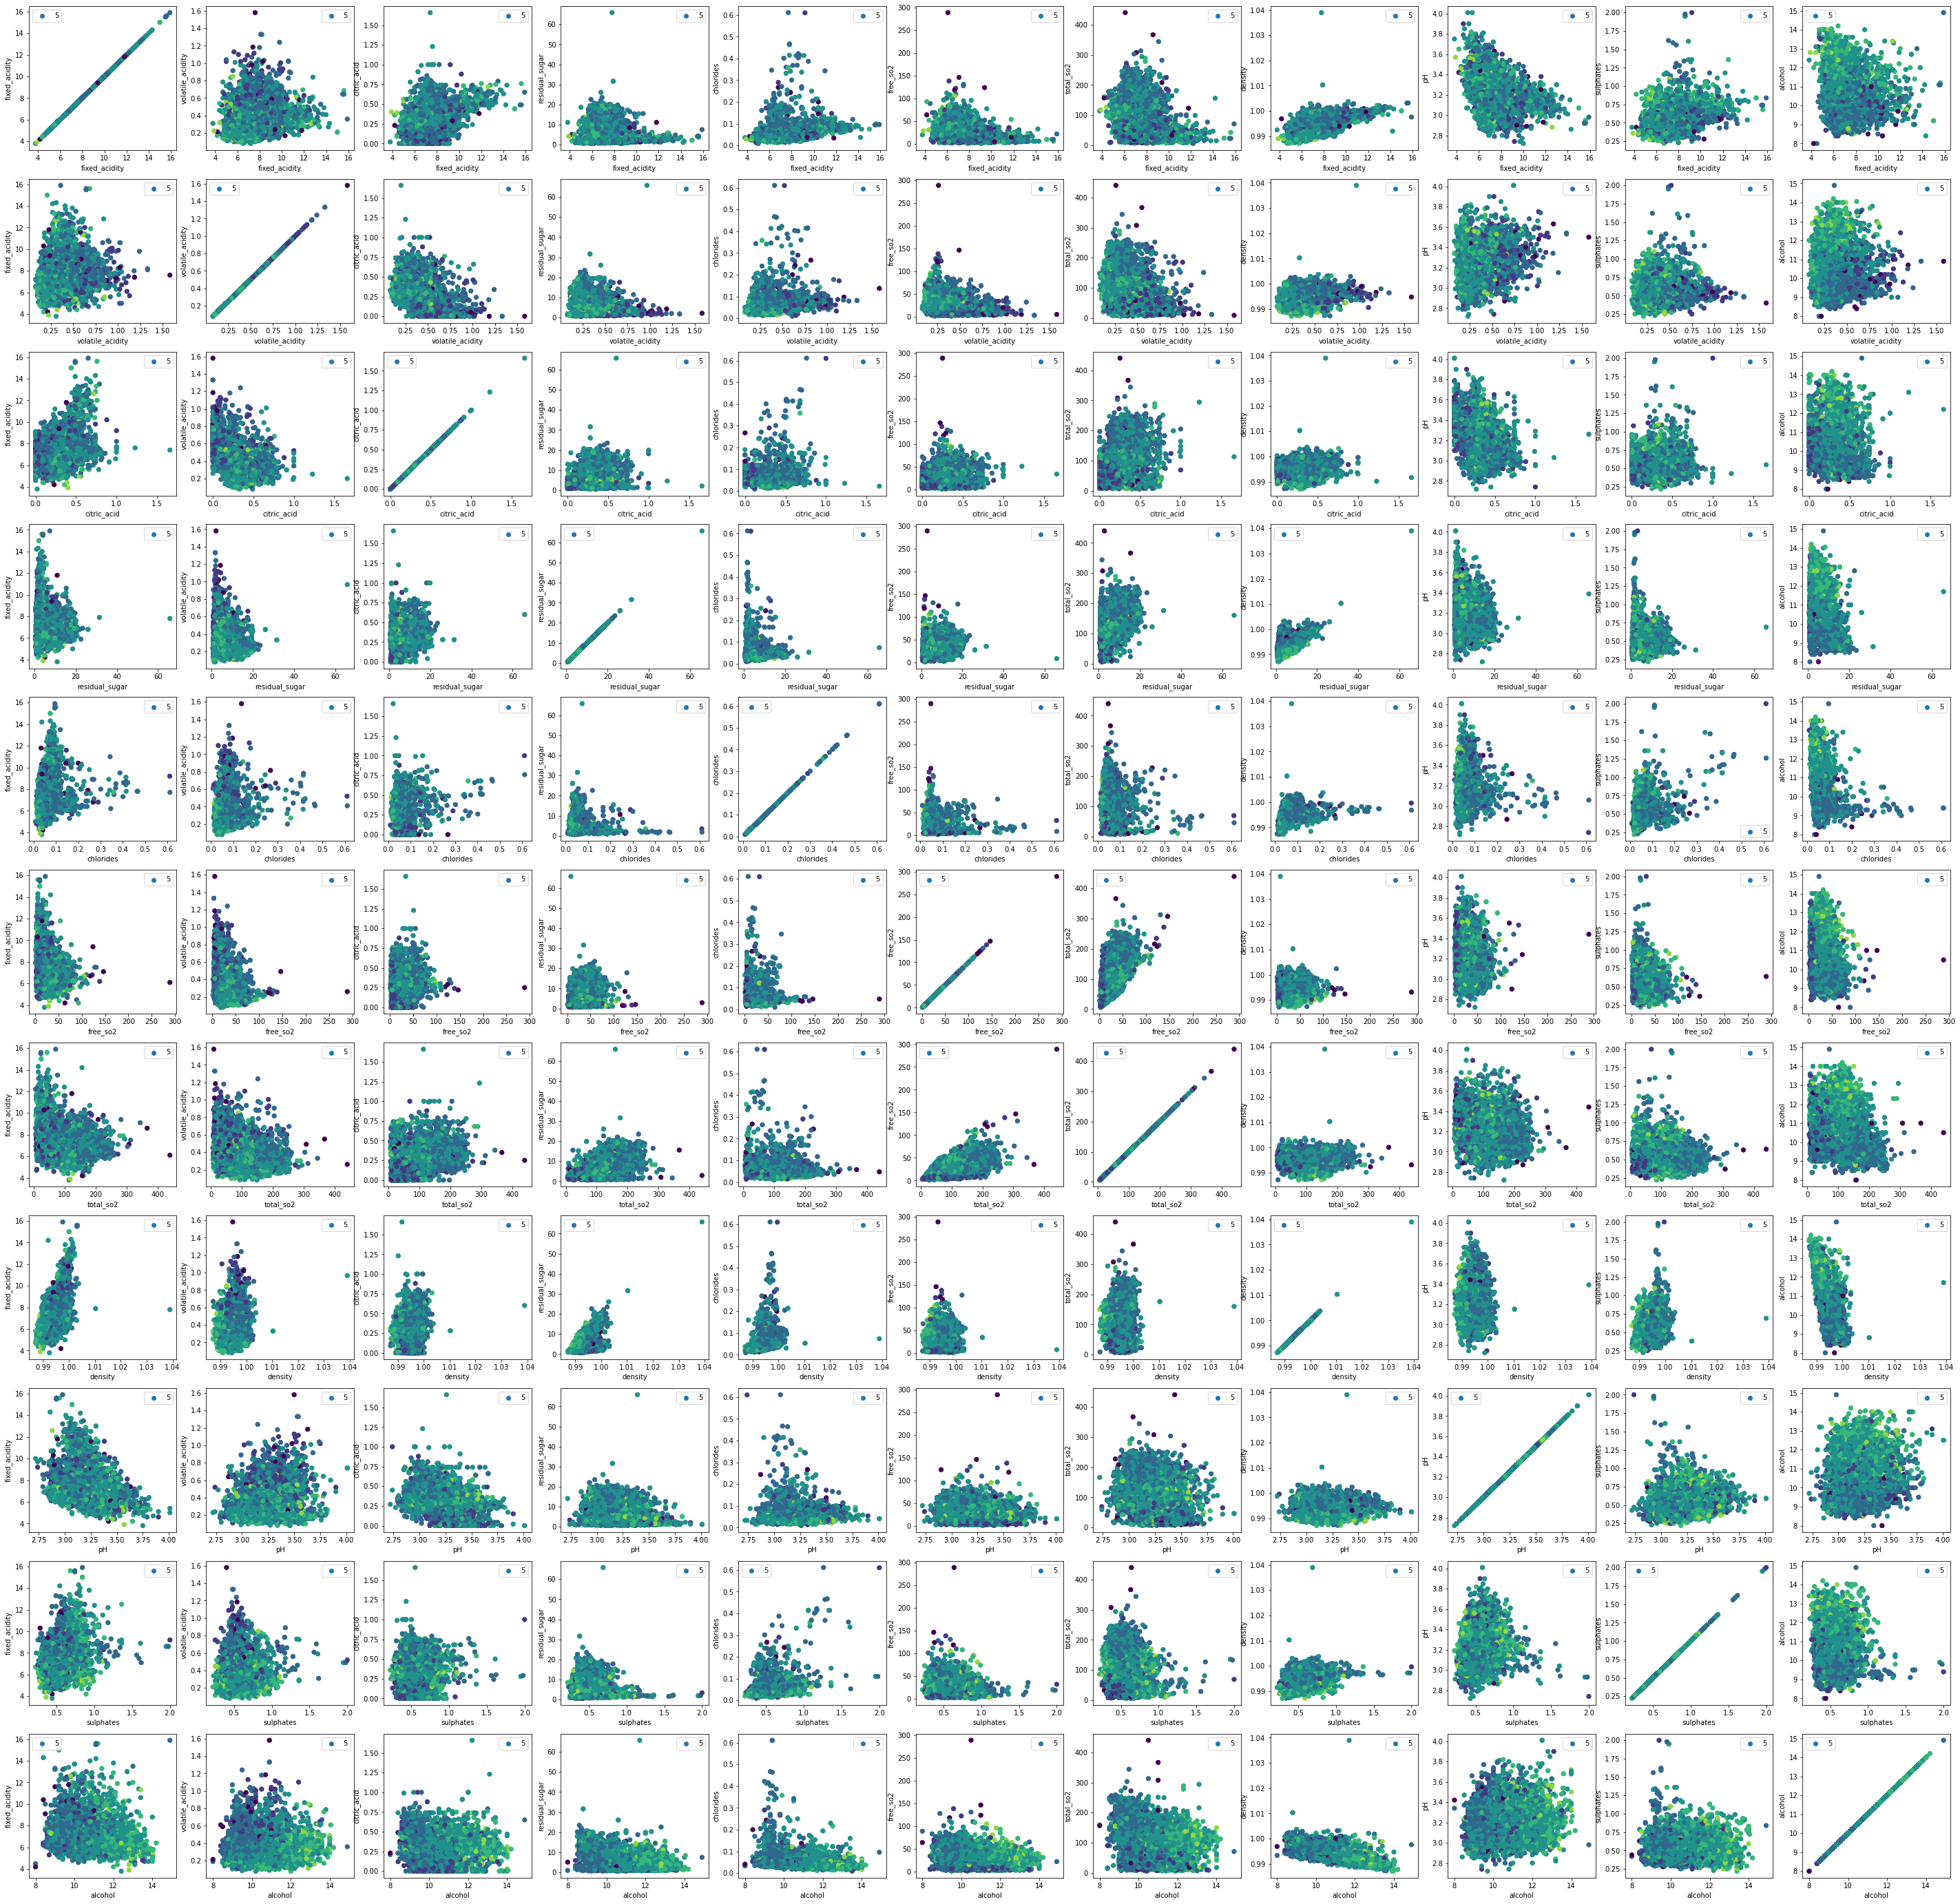

In [92]:
# Since the dataset is not very large, we can convert the whole pyspark dataframe to pandas dataframe and plot it using seaborn
# We could all the analysis using sklearn/pandas, but for exercise, we will do all the modeling in PySpark (only using seaborn/pandas for basic EDA for convenience)
wine_pd = wine_df.toPandas()
wine_pd = wine_pd[wine_pd.columns[:-1]]
fig1, ax = plt.subplots(11, 11, figsize=(50,50))
for i in range(11):
    for j in range(11):
        ax[i][j].scatter(wine_pd.iloc[:,i], wine_pd.iloc[:,j], c=wine_pd['quality'])
        ax[i][j].set_xlabel(wine_pd.columns[i])
        ax[i][j].set_ylabel(wine_pd.columns[j])
        ax[i][j].legend(wine_pd['quality'])
    
plt.savefig('./Images/Scatter_plot_allCols.png')
plt.show()


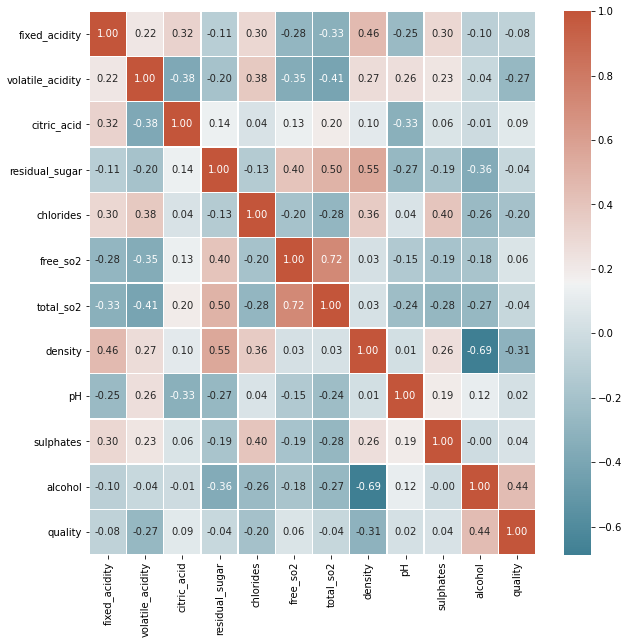

In [93]:
plt.close(fig1)
# Find and plot correlation matrix

corr_mat = wine_pd.corr()
fig2, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=.5, fmt=".2f", ax=ax)
plt.savefig('./Images/Corr_mat.png')
plt.show()

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


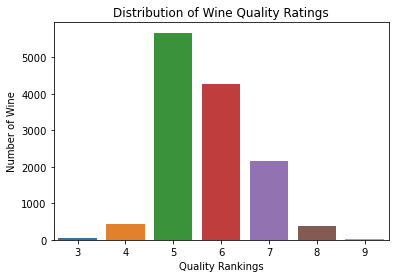

In [94]:
plt.close(fig2)

# Check wine quality numbers
plt.close(1);plt.figure(1)
sns.barplot(wine_pd['quality'].unique(), wine_pd['quality'].value_counts())
plt.xlabel("Quality Rankings")
plt.ylabel("Number of Wine")
plt.title("Distribution of Wine Quality Ratings")
plt.savefig('./Images/Dist_of_quality.png')
plt.show()

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Thomas\ana

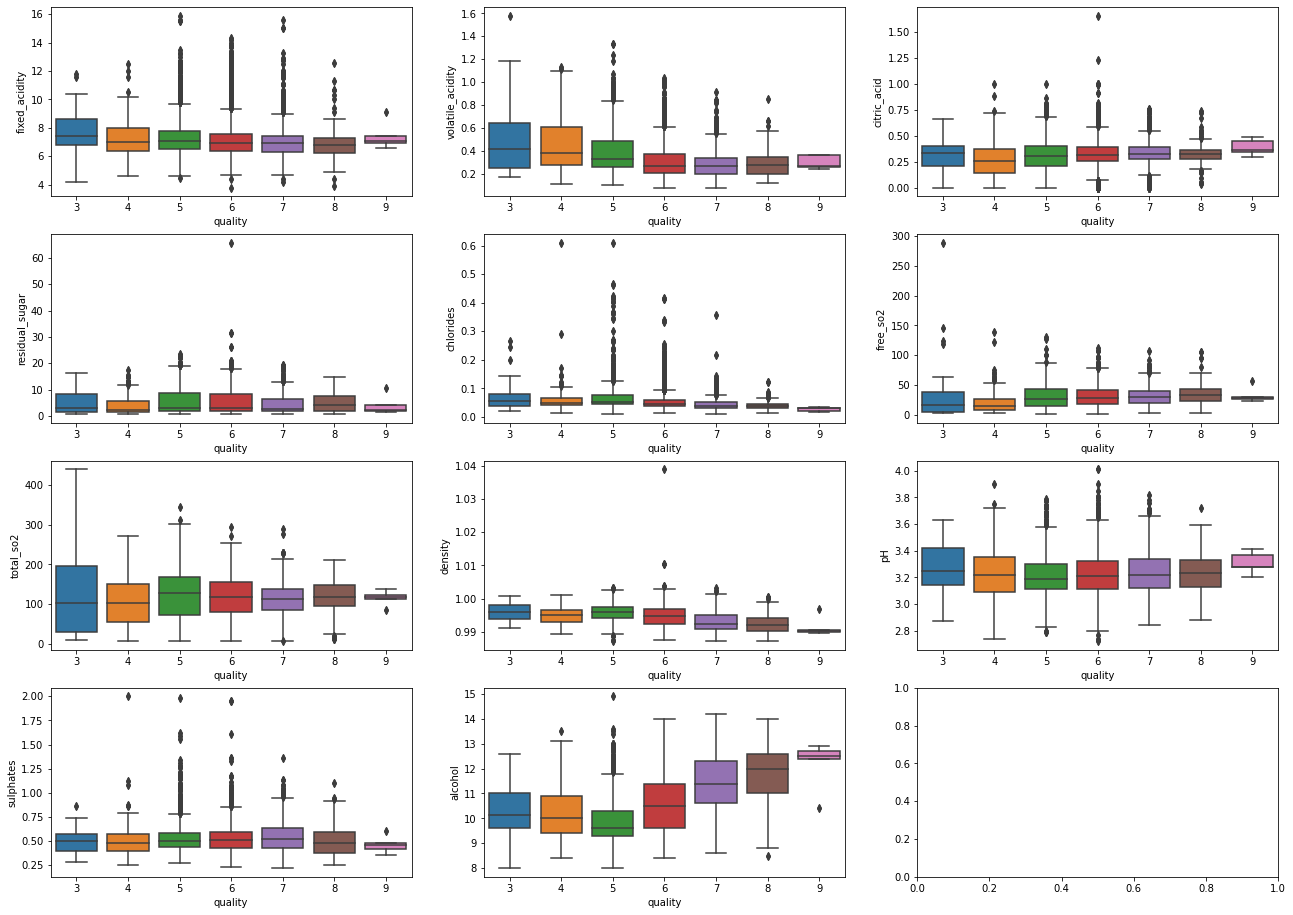

In [95]:
# Check for outliers
fig3, ax = plt.subplots(4, 3, figsize=(22,16))
k = 0
for i in range(4):
    for j in range(3):
        if k != 11:
            sns.boxplot('quality', wine_pd.iloc[:,k], data=wine_pd, ax=ax[i][j])
            k += 1
plt.savefig('./Images/BoxPlots_outliers.png')
plt.show()

In [96]:
plt.close(fig3)

In [137]:
# Finished with the EDA, lets build and fit a model!!!!
# For the sake of the exercise lets say a wine is considered good if its quality is >= 7
from pyspark.sql import functions as f
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer

# categorize data into good quality or bad quality
wine_df = wine_df.withColumn('good_quality', f.when(f.col('quality') >= 6, 1).otherwise(0))
count_good_wine = wine_df.groupby('good_quality').count()

# extract features
features = wine_df.columns[:11]

#label the data
string_label = StringIndexer(inputCol='quality', outputCol='label')
wine_df = string_label.fit(wine_df).transform(wine_df)

#Fit vector assembler
vec_assembler = VectorAssembler(inputCols=features, outputCol='features')
wine_df = vec_assembler.transform(wine_df)

# Scale the data
scaler = StandardScaler(inputCol='features', outputCol='standard_features',withStd=True, withMean=True)
scale_model = scaler.fit(wine_df)
scaled_data = scale_model.transform(wine_df)

# Split the data
train, test = scaled_data.randomSplit([.75, .25], seed=42)


In [138]:
# Look at results from previous cell
count_good_wine.show()
scaled_data.show()

+------------+-----+
|good_quality|count|
+------------+-----+
|           1| 2554|
|           0|10440|
+------------+-----+

+-------------+----------------+-----------+--------------+---------+--------+---------+-------+----+---------+-------+-------+------+------------+--------------------+-----+--------------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_so2|total_so2|density|  pH|sulphates|alcohol|quality|is_red|good_quality|            features|label|   standard_features|
+-------------+----------------+-----------+--------------+---------+--------+---------+-------+----+---------+-------+-------+------+------------+--------------------+-----+--------------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|    11.0|     34.0| 0.9978|3.51|     0.56|    9.4|      5|     1|           0|[7.4,0.7,0.0,1.9,...|  1.0|[0.14246778279371...|
|          7.8|            0.88|        0.0|           2.6|    0.098|    25.0|     67.0| 

In [150]:
# Check schema to make sure datatypes make sense
scaled_data.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_so2: double (nullable = true)
 |-- total_so2: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- is_red: integer (nullable = true)
 |-- good_quality: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- standard_features: vector (nullable = true)



In [151]:
#model 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

random_forest = RandomForestClassifier(labelCol='label', featuresCol='standard_features', impurity='gini', numTrees=500)
rf_model = random_forest.fit(train)
rf_pred = rf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
accuracy = evaluator.evaluate(rf_pred)
print(f'Accuracy = {accuracy:.4f}%')


Accuracy = 0.5091%


# TO DO !!!!!

- increase accuracy to model (aim for at least 70%)
- plot feature importance